# Workforce Wellbeing Analysis - Model Training

Training three separate models to predict:
1. **Burnout Risk Score** (0-1)
2. **Wellbeing Score** (0-100)
3. **Efficiency Score** (0-100)

Using realistic dataset with 300 samples and 110 features.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2. Load and Explore Dataset

In [2]:
# Load the realistic dataset
df = pd.read_csv('dataset/realistic_emp_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"Total samples: {len(df)}")
print(f"Total features: {len(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (300, 113)
Total samples: 300
Total features: 113

First few rows:


,employee_id,age,experience_years,role,work_hours_per_day,days_worked_per_week,overtime_hours,lunch_break_minutes,coffee_breaks_per_day,punctuality_score,...,team_engagement_score,self_directed_work_percentage,decision_making_authority_score,feedback_received_count,feedback_given_count,new_technologies_learned,skill_utilization_score,burnout_risk_score,wellbeing_score,efficiency_score
0,EMP001,35,13,Developer,9.07,5,0.50,45,1,91.55,...,43.55,70.82,46.37,1,0,0,47.84,0.3100,65.10,68.60
1,EMP002,45,11,Developer,8.07,5,13.17,45,2,82.14,...,42.29,48.73,57.47,0,0,0,59.53,0.4327,76.15,42.50
2,EMP003,35,3,Manager,7.01,5,4.10,45,1,85.65,...,47.97,33.18,49.62,3,1,0,75.28,0.2091,81.36,7.47
3,EMP004,25,3,Developer,8.79,5,10.20,60,2,91.58,...,52.48,36.72,67.62,2,1,3,73.20,0.3064,73.59,52.51
4,EMP005,42,14,Manager,8.64,5,0.93,30,2,72.87,...,51.41,71.99,40.41,0,1,0,73.68,0.2489,83.44,3.62


In [3]:
# Check for missing values
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("✓ No missing values found")
else:
    print("Missing values:")
    print(missing_values[missing_values > 0])

# Display data types
print(f"\nData types:\n{df.dtypes.value_counts()}")

✓ No missing values found

Data types:
float64    62
int64      49
object      2
Name: count, dtype: int64


## 3. Exploratory Data Analysis

In [4]:
# Target variable statistics
target_stats = df[['burnout_risk_score', 'wellbeing_score', 'efficiency_score']].describe()
print("Target Variable Statistics:")
target_stats

Target Variable Statistics:


,burnout_risk_score,wellbeing_score,efficiency_score
count,300.000000,300.000000,300.000000
mean,0.341834,76.612100,43.782233
std,0.179438,8.678383,26.210776
min,0.000000,47.270000,0.000000
25%,0.225275,71.427500,11.915000
50%,0.321650,76.510000,52.200000
75%,0.449250,82.735000,63.807500
max,1.000000,99.910000,100.000000


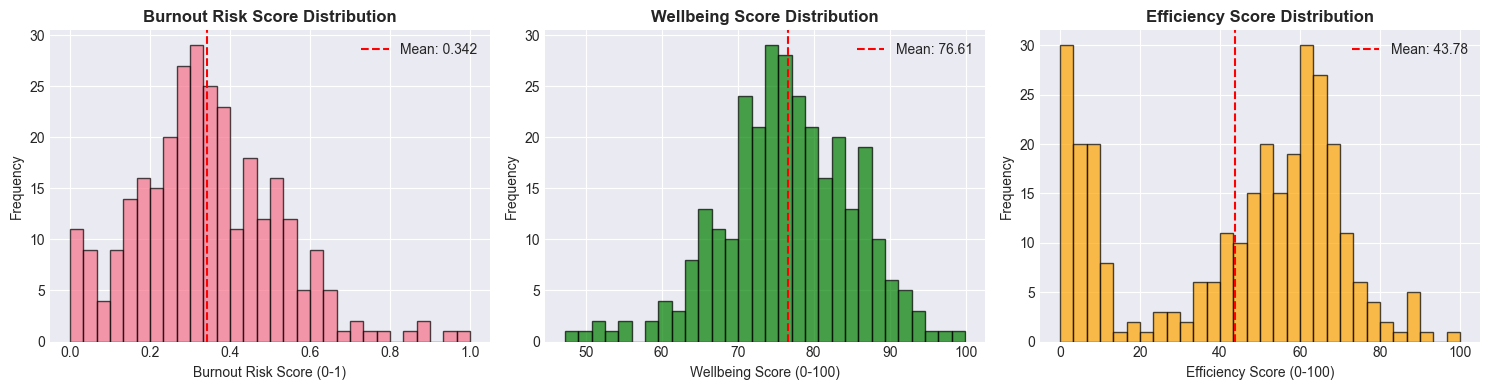

✓ Target variable distributions plotted


In [5]:
# Visualize target variable distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Burnout Risk Score
axes[0].hist(df['burnout_risk_score'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Burnout Risk Score Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Burnout Risk Score (0-1)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['burnout_risk_score'].mean(), color='red', linestyle='--', label=f'Mean: {df["burnout_risk_score"].mean():.3f}')
axes[0].legend()

# Wellbeing Score
axes[1].hist(df['wellbeing_score'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Wellbeing Score Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Wellbeing Score (0-100)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(df['wellbeing_score'].mean(), color='red', linestyle='--', label=f'Mean: {df["wellbeing_score"].mean():.2f}')
axes[1].legend()

# Efficiency Score
axes[2].hist(df['efficiency_score'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[2].set_title('Efficiency Score Distribution', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Efficiency Score (0-100)')
axes[2].set_ylabel('Frequency')
axes[2].axvline(df['efficiency_score'].mean(), color='red', linestyle='--', label=f'Mean: {df["efficiency_score"].mean():.2f}')
axes[2].legend()

plt.tight_layout()
plt.show()

print("✓ Target variable distributions plotted")

Role Distribution:
role
Developer           103
Senior Developer     74
Tech Lead            42
Manager              38
Designer             31
QA Engineer          12
Name: count, dtype: int64

Role Percentages:
role
Developer           34.333333
Senior Developer    24.666667
Tech Lead           14.000000
Manager             12.666667
Designer            10.333333
QA Engineer          4.000000
Name: count, dtype: float64


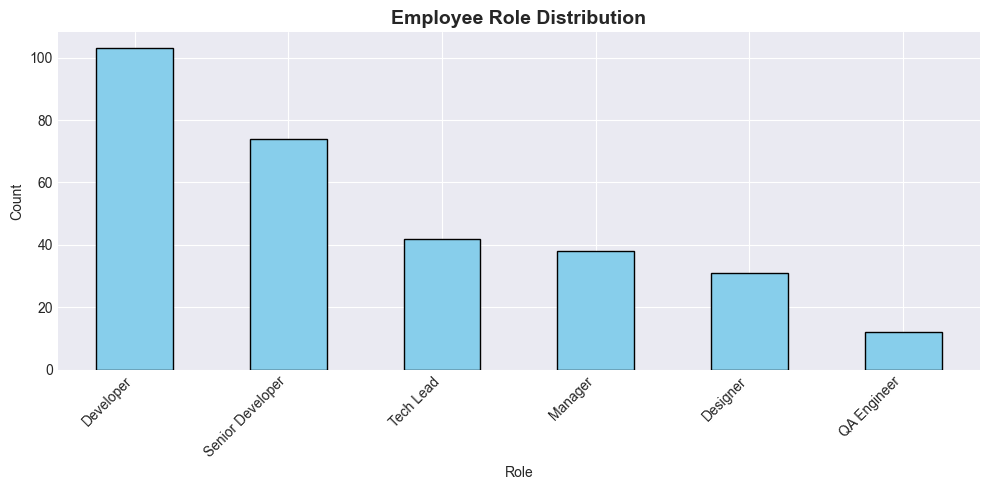

In [6]:
# Role distribution
role_counts = df['role'].value_counts()
print("Role Distribution:")
print(role_counts)
print(f"\nRole Percentages:")
print(role_counts / len(df) * 100)

# Visualize role distribution
plt.figure(figsize=(10, 5))
role_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Employee Role Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Role')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Target Variable Correlations:
                    burnout_risk_score  wellbeing_score  efficiency_score
burnout_risk_score            1.000000        -0.699436         -0.100486
wellbeing_score              -0.699436         1.000000          0.073861
efficiency_score             -0.100486         0.073861          1.000000


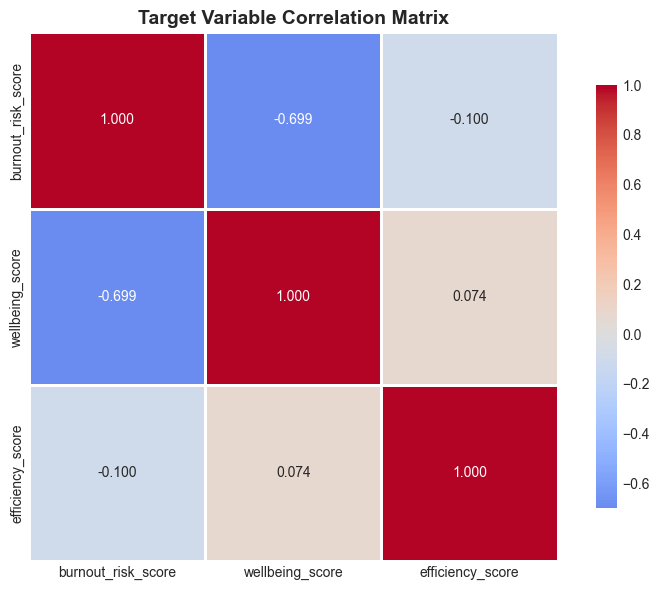

In [7]:
# Correlation between targets
target_corr = df[['burnout_risk_score', 'wellbeing_score', 'efficiency_score']].corr()
print("Target Variable Correlations:")
print(target_corr)

plt.figure(figsize=(8, 6))
sns.heatmap(target_corr, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Target Variable Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Data Preparation

In [8]:
# Separate features and targets
X = df.drop(['employee_id', 'burnout_risk_score', 'wellbeing_score', 'efficiency_score'], axis=1)
y_burnout = df['burnout_risk_score']
y_wellbeing = df['wellbeing_score']
y_efficiency = df['efficiency_score']

print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"\nFeature columns:")
print(list(X.columns))

Feature matrix shape: (300, 109)
Number of features: 109

Feature columns:
['age', 'experience_years', 'role', 'work_hours_per_day', 'days_worked_per_week', 'overtime_hours', 'lunch_break_minutes', 'coffee_breaks_per_day', 'punctuality_score', 'attendance_rate', 'late_arrivals', 'biometric_match_score', 'emails_sent', 'emails_received', 'email_response_time', 'after_hours_emails', 'meetings_per_week', 'meeting_hours', 'meeting_acceptance_rate', 'declined_meetings', 'focus_time_hours', 'messages_sent', 'messages_received', 'after_hours_messages', 'response_time_minutes', 'reactions_given', 'status_available_percentage', 'status_busy_percentage', 'status_away_percentage', 'commits_per_week', 'prs_created', 'prs_reviewed', 'code_review_time_hours', 'pr_merge_rate', 'avg_pr_size_lines', 'github_pr_merge_time', 'tasks_assigned', 'tasks_completed_per_week', 'task_completion_rate', 'overdue_tasks', 'avg_task_completion_time', 'hours_logged', 'projects_active', 'context_switches_per_day', 'bug

In [9]:
# One-hot encode categorical variable (role)
X_encoded = pd.get_dummies(X, columns=['role'], prefix='role', drop_first=False)

print(f"Encoded feature matrix shape: {X_encoded.shape}")
print(f"Number of features after encoding: {X_encoded.shape[1]}")
print(f"\nNew role columns: {[col for col in X_encoded.columns if col.startswith('role_')]}")

Encoded feature matrix shape: (300, 114)
Number of features after encoding: 114

New role columns: ['role_Designer', 'role_Developer', 'role_Manager', 'role_QA Engineer', 'role_Senior Developer', 'role_Tech Lead']


In [10]:
# Save feature columns for later use
feature_columns = list(X_encoded.columns)
print(f"Total features for training: {len(feature_columns)}")

Total features for training: 114


## 5. Model Training Functions

In [11]:
def train_models(X_train, y_train, X_test, y_test, target_name):
    """
    Train multiple models and select the best one using cross-validation.
    
    Args:
        X_train: Training features
        y_train: Training target
        X_test: Test features
        y_test: Test target
        target_name: Name of the target variable
    
    Returns:
        Tuple of (best_model, model_name, cv_scores, metrics)
    """
    print(f"\n{'='*60}")
    print(f"Training models for: {target_name}")
    print(f"{'='*60}")
    
    # Define models to test
    models = {
        'XGBoost': XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1),
        'GradientBoosting': GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1),
        'RandomForest': RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)
    }
    
    best_score = -float('inf')
    best_model = None
    best_model_name = None
    all_cv_scores = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Perform 5-fold cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        mean_cv_score = cv_scores.mean()
        all_cv_scores[name] = cv_scores
        
        print(f"  CV R² scores: {cv_scores}")
        print(f"  Mean CV R²: {mean_cv_score:.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Track best model
        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_model = model
            best_model_name = name
    
    # Train best model on full training set
    print(f"\n{'='*60}")
    print(f"Best model: {best_model_name} (CV R²: {best_score:.4f})")
    print(f"Training {best_model_name} on full training set...")
    best_model.fit(X_train, y_train)
    
    # Evaluate on train and test sets
    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)
    
    metrics = {
        'model_name': best_model_name,
        'cv_mean_r2': float(best_score),
        'cv_std_r2': float(all_cv_scores[best_model_name].std()),
        'train_r2': float(r2_score(y_train, train_pred)),
        'test_r2': float(r2_score(y_test, test_pred)),
        'train_rmse': float(np.sqrt(mean_squared_error(y_train, train_pred))),
        'test_rmse': float(np.sqrt(mean_squared_error(y_test, test_pred))),
        'train_mae': float(mean_absolute_error(y_train, train_pred)),
        'test_mae': float(mean_absolute_error(y_test, test_pred))
    }
    
    print(f"\nTraining Metrics:")
    print(f"  R²: {metrics['train_r2']:.4f}")
    print(f"  RMSE: {metrics['train_rmse']:.4f}")
    print(f"  MAE: {metrics['train_mae']:.4f}")
    
    print(f"\nTest Metrics:")
    print(f"  R²: {metrics['test_r2']:.4f}")
    print(f"  RMSE: {metrics['test_rmse']:.4f}")
    print(f"  MAE: {metrics['test_mae']:.4f}")
    
    return best_model, best_model_name, all_cv_scores, metrics

print("✓ Model training function defined")

✓ Model training function defined


In [12]:
def plot_predictions(y_true, y_pred, title, target_name):
    """
    Plot actual vs predicted values.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolor='black')
    
    # Plot perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("✓ Prediction plotting function defined")

✓ Prediction plotting function defined


In [13]:
def get_feature_importance(model, feature_names, top_n=15):
    """
    Extract and plot feature importance.
    """
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        return importance_df
    else:
        return None

def plot_feature_importance(importance_df, title, top_n=15):
    """
    Plot top N most important features.
    """
    if importance_df is not None:
        plt.figure(figsize=(10, 8))
        top_features = importance_df.head(top_n)
        plt.barh(range(len(top_features)), top_features['importance'], color='steelblue', edgecolor='black')
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importance')
        plt.title(title, fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

print("✓ Feature importance functions defined")

✓ Feature importance functions defined


## 6. Train Model 1: Burnout Risk Score

In [14]:
# Split data for burnout risk model
X_train_burnout, X_test_burnout, y_train_burnout, y_test_burnout = train_test_split(
    X_encoded, y_burnout, test_size=0.2, random_state=42
)

# Scale features
scaler_burnout = StandardScaler()
X_train_burnout_scaled = scaler_burnout.fit_transform(X_train_burnout)
X_test_burnout_scaled = scaler_burnout.transform(X_test_burnout)

print(f"Training set size: {X_train_burnout_scaled.shape[0]}")
print(f"Test set size: {X_test_burnout_scaled.shape[0]}")

Training set size: 240
Test set size: 60


In [15]:
# Train models for burnout risk
model_burnout, model_name_burnout, cv_scores_burnout, metrics_burnout = train_models(
    X_train_burnout_scaled, y_train_burnout,
    X_test_burnout_scaled, y_test_burnout,
    'Burnout Risk Score'
)


Training models for: Burnout Risk Score

Training XGBoost...
  CV R² scores: [0.43256534 0.50866952 0.63467928 0.30389947 0.56854708]
  Mean CV R²: 0.4897 (+/- 0.2287)

Training GradientBoosting...
  CV R² scores: [0.43256534 0.50866952 0.63467928 0.30389947 0.56854708]
  Mean CV R²: 0.4897 (+/- 0.2287)

Training GradientBoosting...
  CV R² scores: [0.51003418 0.58635236 0.67555546 0.39752396 0.55698181]
  Mean CV R²: 0.5453 (+/- 0.1830)

Training RandomForest...
  CV R² scores: [0.51003418 0.58635236 0.67555546 0.39752396 0.55698181]
  Mean CV R²: 0.5453 (+/- 0.1830)

Training RandomForest...
  CV R² scores: [0.48746997 0.57426994 0.67072551 0.42167928 0.61844067]
  Mean CV R²: 0.5545 (+/- 0.1792)

Best model: RandomForest (CV R²: 0.5545)
Training RandomForest on full training set...
  CV R² scores: [0.48746997 0.57426994 0.67072551 0.42167928 0.61844067]
  Mean CV R²: 0.5545 (+/- 0.1792)

Best model: RandomForest (CV R²: 0.5545)
Training RandomForest on full training set...

Trainin

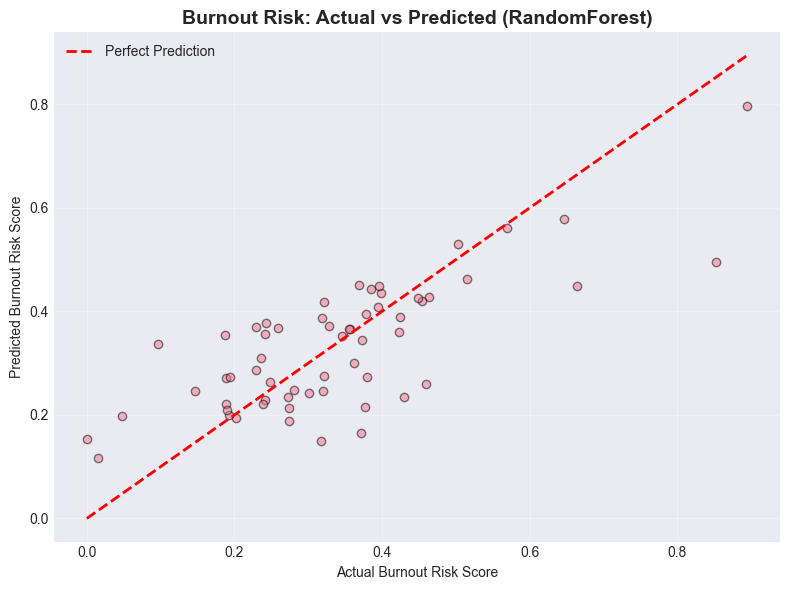

In [16]:
# Plot predictions for burnout risk
y_pred_burnout_test = model_burnout.predict(X_test_burnout_scaled)
plot_predictions(y_test_burnout, y_pred_burnout_test, 
                f'Burnout Risk: Actual vs Predicted ({model_name_burnout})',
                'Burnout Risk Score')


Top 15 Features for Burnout Risk Prediction:
                        feature  importance
16                meeting_hours    0.375977
59      work_life_balance_score    0.100082
58           daily_active_hours    0.098897
50        meeting_to_work_ratio    0.062514
15            meetings_per_week    0.021876
4                overtime_hours    0.012914
75             initiative_score    0.010186
56      email_after_hours_ratio    0.010021
40                 hours_logged    0.009334
87  meeting_participation_score    0.008515
19             focus_time_hours    0.008295
73         sentiment_chat_score    0.008132
2            work_hours_per_day    0.007913
98   morning_productivity_score    0.007660
7             punctuality_score    0.006708


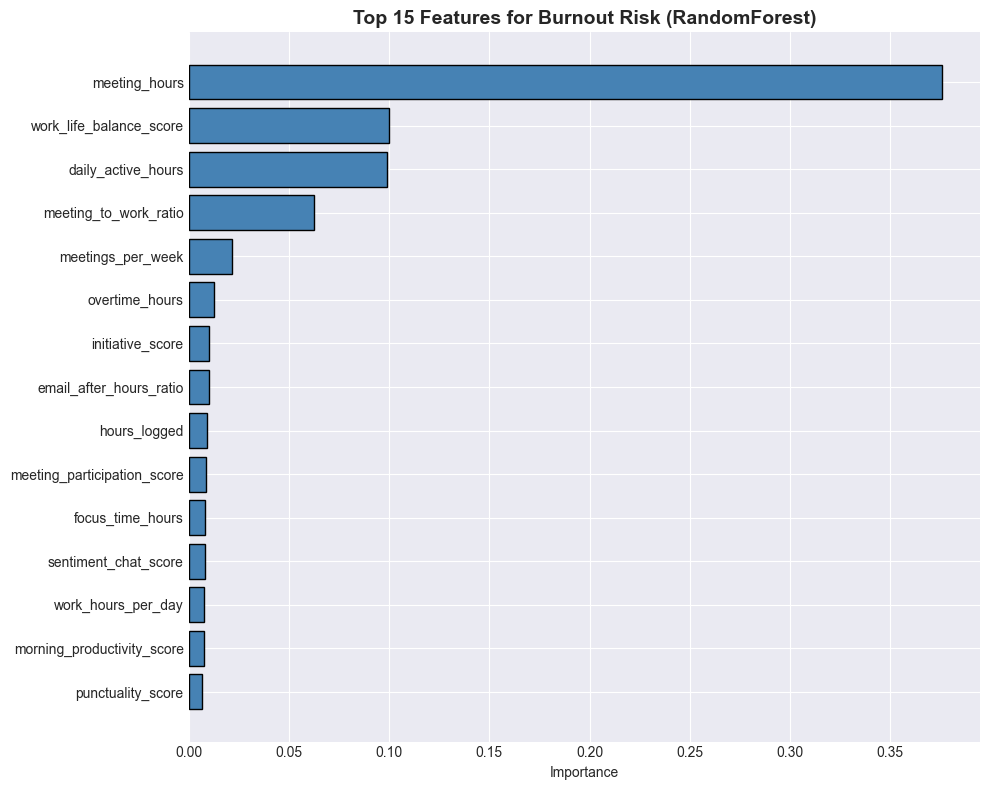

In [17]:
# Feature importance for burnout risk
importance_burnout = get_feature_importance(model_burnout, feature_columns)
if importance_burnout is not None:
    print("\nTop 15 Features for Burnout Risk Prediction:")
    print(importance_burnout.head(15))
    plot_feature_importance(importance_burnout, 
                          f'Top 15 Features for Burnout Risk ({model_name_burnout})')

## 7. Train Model 2: Wellbeing Score

In [18]:
# Split data for wellbeing model
X_train_wellbeing, X_test_wellbeing, y_train_wellbeing, y_test_wellbeing = train_test_split(
    X_encoded, y_wellbeing, test_size=0.2, random_state=42
)

# Scale features
scaler_wellbeing = StandardScaler()
X_train_wellbeing_scaled = scaler_wellbeing.fit_transform(X_train_wellbeing)
X_test_wellbeing_scaled = scaler_wellbeing.transform(X_test_wellbeing)

print(f"Training set size: {X_train_wellbeing_scaled.shape[0]}")
print(f"Test set size: {X_test_wellbeing_scaled.shape[0]}")

Training set size: 240
Test set size: 60


In [19]:
# Train models for wellbeing
model_wellbeing, model_name_wellbeing, cv_scores_wellbeing, metrics_wellbeing = train_models(
    X_train_wellbeing_scaled, y_train_wellbeing,
    X_test_wellbeing_scaled, y_test_wellbeing,
    'Wellbeing Score'
)


Training models for: Wellbeing Score

Training XGBoost...
  CV R² scores: [0.40322809 0.14989212 0.20398788 0.50096414 0.36539405]
  Mean CV R²: 0.3247 (+/- 0.2593)

Training GradientBoosting...
  CV R² scores: [0.40322809 0.14989212 0.20398788 0.50096414 0.36539405]
  Mean CV R²: 0.3247 (+/- 0.2593)

Training GradientBoosting...
  CV R² scores: [0.46848928 0.35258265 0.29744168 0.47450627 0.4886782 ]
  Mean CV R²: 0.4163 (+/- 0.1537)

Training RandomForest...
  CV R² scores: [0.46848928 0.35258265 0.29744168 0.47450627 0.4886782 ]
  Mean CV R²: 0.4163 (+/- 0.1537)

Training RandomForest...
  CV R² scores: [0.43340776 0.41049541 0.27457942 0.40627563 0.4095073 ]
  Mean CV R²: 0.3869 (+/- 0.1139)

Best model: GradientBoosting (CV R²: 0.4163)
Training GradientBoosting on full training set...
  CV R² scores: [0.43340776 0.41049541 0.27457942 0.40627563 0.4095073 ]
  Mean CV R²: 0.3869 (+/- 0.1139)

Best model: GradientBoosting (CV R²: 0.4163)
Training GradientBoosting on full training se

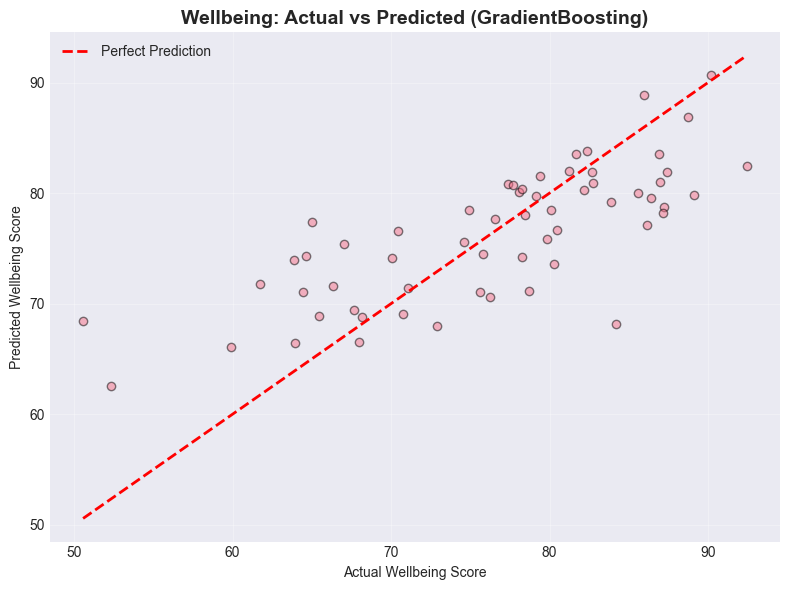

In [20]:
# Plot predictions for wellbeing
y_pred_wellbeing_test = model_wellbeing.predict(X_test_wellbeing_scaled)
plot_predictions(y_test_wellbeing, y_pred_wellbeing_test,
                f'Wellbeing: Actual vs Predicted ({model_name_wellbeing})',
                'Wellbeing Score')


Top 15 Features for Wellbeing Prediction:
                      feature  importance
101     team_engagement_score    0.184122
50      meeting_to_work_ratio    0.131687
59    work_life_balance_score    0.123439
16              meeting_hours    0.096266
58         daily_active_hours    0.052518
4              overtime_hours    0.044632
57         weekend_work_hours    0.019120
2          work_hours_per_day    0.018557
85              response_rate    0.017070
91        task_switching_rate    0.016309
63      tool_switch_frequency    0.015461
106  new_technologies_learned    0.014271
44                 bugs_fixed    0.011036
40               hours_logged    0.011031
19           focus_time_hours    0.011011


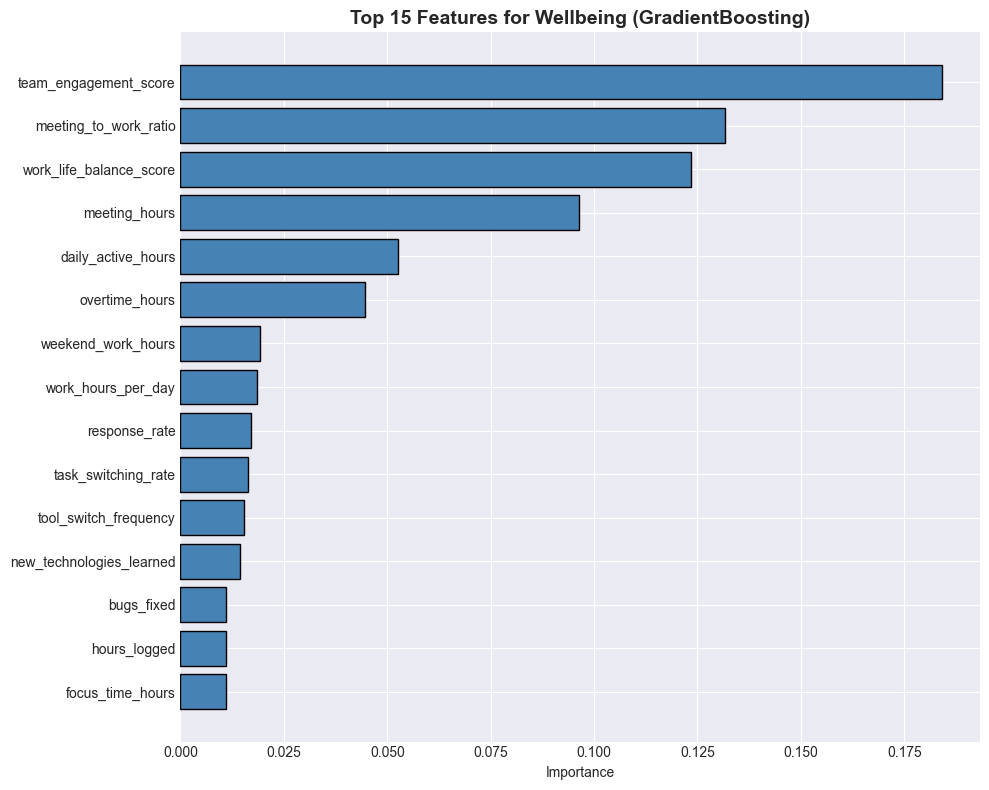

In [21]:
# Feature importance for wellbeing
importance_wellbeing = get_feature_importance(model_wellbeing, feature_columns)
if importance_wellbeing is not None:
    print("\nTop 15 Features for Wellbeing Prediction:")
    print(importance_wellbeing.head(15))
    plot_feature_importance(importance_wellbeing,
                          f'Top 15 Features for Wellbeing ({model_name_wellbeing})')

## 8. Train Model 3: Efficiency Score

In [22]:
# Split data for efficiency model
X_train_efficiency, X_test_efficiency, y_train_efficiency, y_test_efficiency = train_test_split(
    X_encoded, y_efficiency, test_size=0.2, random_state=42
)

# Scale features
scaler_efficiency = StandardScaler()
X_train_efficiency_scaled = scaler_efficiency.fit_transform(X_train_efficiency)
X_test_efficiency_scaled = scaler_efficiency.transform(X_test_efficiency)

print(f"Training set size: {X_train_efficiency_scaled.shape[0]}")
print(f"Test set size: {X_test_efficiency_scaled.shape[0]}")

Training set size: 240
Test set size: 60


In [23]:
# Train models for efficiency
model_efficiency, model_name_efficiency, cv_scores_efficiency, metrics_efficiency = train_models(
    X_train_efficiency_scaled, y_train_efficiency,
    X_test_efficiency_scaled, y_test_efficiency,
    'Efficiency Score'
)


Training models for: Efficiency Score

Training XGBoost...
  CV R² scores: [0.90537263 0.94662831 0.94780129 0.96091849 0.96061396]
  Mean CV R²: 0.9443 (+/- 0.0407)

Training GradientBoosting...
  CV R² scores: [0.90537263 0.94662831 0.94780129 0.96091849 0.96061396]
  Mean CV R²: 0.9443 (+/- 0.0407)

Training GradientBoosting...
  CV R² scores: [0.94987074 0.95919975 0.96698686 0.95158756 0.9768615 ]
  Mean CV R²: 0.9609 (+/- 0.0201)

Training RandomForest...
  CV R² scores: [0.94987074 0.95919975 0.96698686 0.95158756 0.9768615 ]
  Mean CV R²: 0.9609 (+/- 0.0201)

Training RandomForest...
  CV R² scores: [0.92881432 0.94783833 0.93342276 0.94380301 0.96266558]
  Mean CV R²: 0.9433 (+/- 0.0237)

Best model: GradientBoosting (CV R²: 0.9609)
Training GradientBoosting on full training set...
  CV R² scores: [0.92881432 0.94783833 0.93342276 0.94380301 0.96266558]
  Mean CV R²: 0.9433 (+/- 0.0237)

Best model: GradientBoosting (CV R²: 0.9609)
Training GradientBoosting on full training s

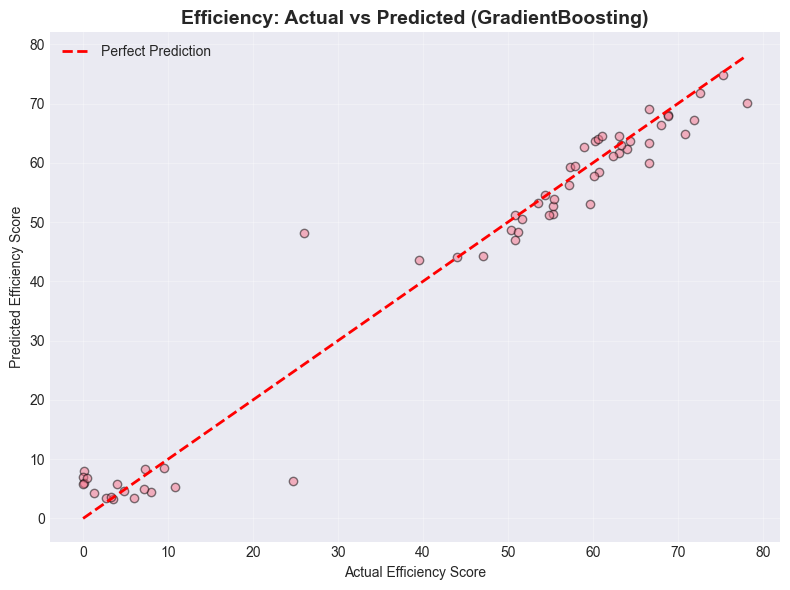

In [24]:
# Plot predictions for efficiency
y_pred_efficiency_test = model_efficiency.predict(X_test_efficiency_scaled)
plot_predictions(y_test_efficiency, y_pred_efficiency_test,
                f'Efficiency: Actual vs Predicted ({model_name_efficiency})',
                'Efficiency Score')


Top 15 Features for Efficiency Prediction:
                          feature  importance
28               commits_per_week    0.283132
33              avg_pr_size_lines    0.207476
32                  pr_merge_rate    0.126349
37           task_completion_rate    0.087853
29                    prs_created    0.080622
78  code_review_comments_received    0.072433
68         deliverables_completed    0.052183
50          meeting_to_work_ratio    0.020812
16                  meeting_hours    0.017530
36       tasks_completed_per_week    0.012059
52                  task_velocity    0.011113
51        code_commit_consistency    0.008099
15              meetings_per_week    0.002792
69                  quality_score    0.002791
80             blocked_time_hours    0.000959


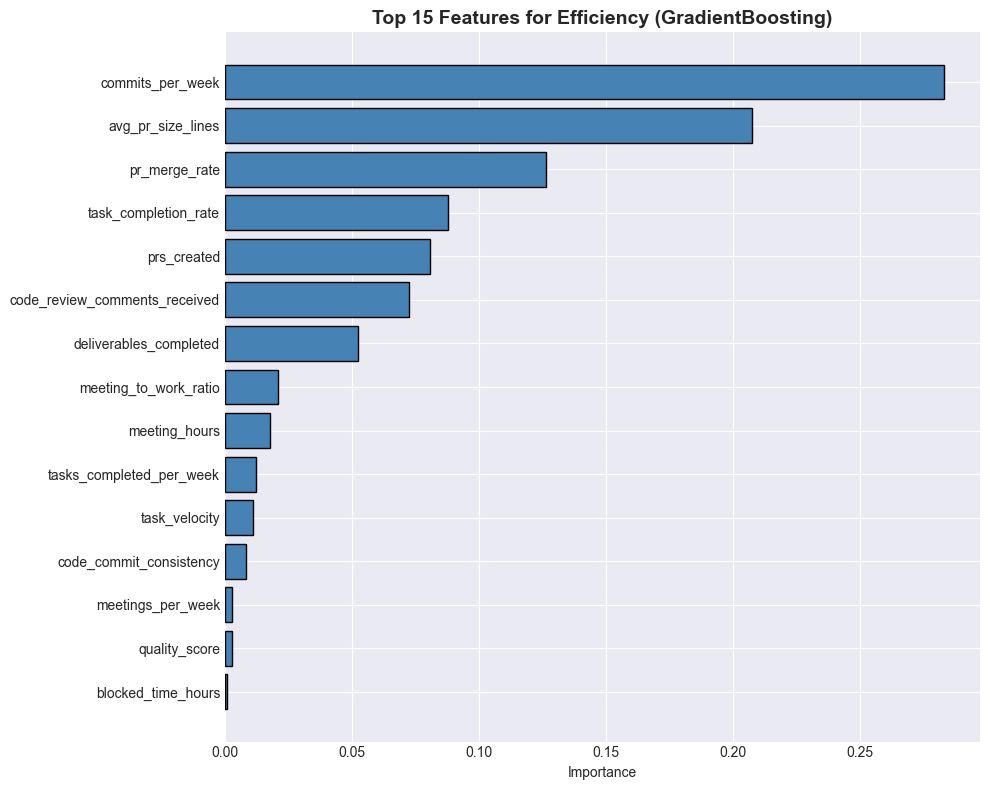

In [25]:
# Feature importance for efficiency
importance_efficiency = get_feature_importance(model_efficiency, feature_columns)
if importance_efficiency is not None:
    print("\nTop 15 Features for Efficiency Prediction:")
    print(importance_efficiency.head(15))
    plot_feature_importance(importance_efficiency,
                          f'Top 15 Features for Efficiency ({model_name_efficiency})')

## 9. Model Comparison

In [26]:
# Compare all models
comparison_df = pd.DataFrame({
    'Model': ['Burnout Risk', 'Wellbeing', 'Efficiency'],
    'Algorithm': [model_name_burnout, model_name_wellbeing, model_name_efficiency],
    'CV R²': [metrics_burnout['cv_mean_r2'], metrics_wellbeing['cv_mean_r2'], metrics_efficiency['cv_mean_r2']],
    'Train R²': [metrics_burnout['train_r2'], metrics_wellbeing['train_r2'], metrics_efficiency['train_r2']],
    'Test R²': [metrics_burnout['test_r2'], metrics_wellbeing['test_r2'], metrics_efficiency['test_r2']],
    'Test RMSE': [metrics_burnout['test_rmse'], metrics_wellbeing['test_rmse'], metrics_efficiency['test_rmse']],
    'Test MAE': [metrics_burnout['test_mae'], metrics_wellbeing['test_mae'], metrics_efficiency['test_mae']]
})

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)


MODEL COMPARISON SUMMARY
       Model        Algorithm    CV R²  Train R²  Test R²  Test RMSE  Test MAE
Burnout Risk     RandomForest 0.554517  0.939755 0.582711   0.106797  0.080884
   Wellbeing GradientBoosting 0.416340  0.974394 0.564516   6.177841  4.825604
  Efficiency GradientBoosting 0.960901  0.998876 0.963414   5.021586  3.271649


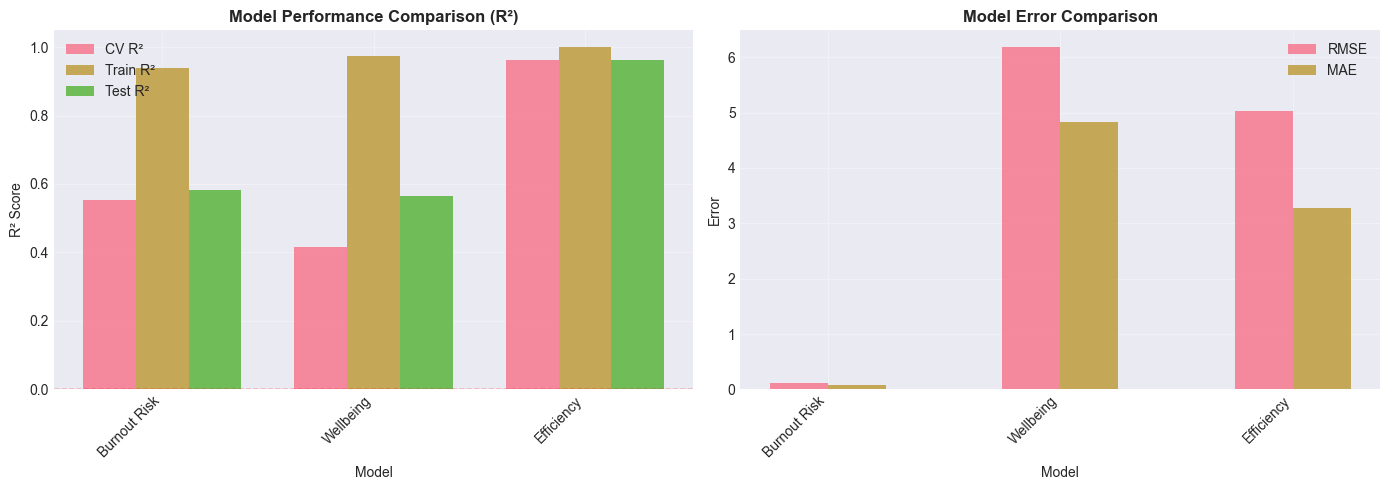

In [27]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
x_pos = np.arange(len(comparison_df))
width = 0.25

axes[0].bar(x_pos - width, comparison_df['CV R²'], width, label='CV R²', alpha=0.8)
axes[0].bar(x_pos, comparison_df['Train R²'], width, label='Train R²', alpha=0.8)
axes[0].bar(x_pos + width, comparison_df['Test R²'], width, label='Test R²', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Model Performance Comparison (R²)', fontsize=12, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)

# Error comparison
axes[1].bar(x_pos - width/2, comparison_df['Test RMSE'], width, label='RMSE', alpha=0.8)
axes[1].bar(x_pos + width/2, comparison_df['Test MAE'], width, label='MAE', alpha=0.8)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Error')
axes[1].set_title('Model Error Comparison', fontsize=12, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Save Models and Artifacts

In [28]:
# Create output directory
import os

output_dir = 'model_realistic'
os.makedirs(output_dir, exist_ok=True)

print(f"Created output directory: {output_dir}")

Created output directory: model_realistic


In [29]:
# Save models
joblib.dump(model_burnout, f'{output_dir}/burnout_risk_model.pkl')
joblib.dump(model_wellbeing, f'{output_dir}/wellbeing_model.pkl')
joblib.dump(model_efficiency, f'{output_dir}/efficiency_model.pkl')

print("✓ Models saved")

✓ Models saved


In [30]:
# Save scalers
joblib.dump(scaler_burnout, f'{output_dir}/burnout_risk_scaler.pkl')
joblib.dump(scaler_wellbeing, f'{output_dir}/wellbeing_scaler.pkl')
joblib.dump(scaler_efficiency, f'{output_dir}/efficiency_scaler.pkl')

print("✓ Scalers saved")

✓ Scalers saved


In [31]:
# Save feature columns
with open(f'{output_dir}/feature_columns.json', 'w') as f:
    json.dump(feature_columns, f, indent=2)

print("✓ Feature columns saved")

✓ Feature columns saved


In [32]:
# Save feature importance
if importance_burnout is not None:
    importance_burnout.to_csv(f'{output_dir}/burnout_risk_feature_importance.csv', index=False)

if importance_wellbeing is not None:
    importance_wellbeing.to_csv(f'{output_dir}/wellbeing_feature_importance.csv', index=False)

if importance_efficiency is not None:
    importance_efficiency.to_csv(f'{output_dir}/efficiency_feature_importance.csv', index=False)

print("✓ Feature importance saved")

✓ Feature importance saved


In [33]:
# Save model metrics
all_metrics = {
    'burnout_risk': metrics_burnout,
    'wellbeing': metrics_wellbeing,
    'efficiency': metrics_efficiency,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset': 'realistic_emp_data.csv',
    'total_samples': len(df),
    'total_features': len(feature_columns),
    'test_size': 0.2
}

with open(f'{output_dir}/model_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=2)

print("✓ Model metrics saved")

✓ Model metrics saved


In [34]:
# Generate training summary report
summary_report = f"""
{'='*80}
WORKFORCE WELLBEING ANALYSIS - MODEL TRAINING SUMMARY
{'='*80}

Training Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Dataset: realistic_emp_data.csv
Total Samples: {len(df)}
Training Samples: {len(X_train_burnout)}
Test Samples: {len(X_test_burnout)}
Total Features: {len(feature_columns)}

{'='*80}
MODEL 1: BURNOUT RISK SCORE
{'='*80}
Algorithm: {model_name_burnout}
Cross-Validation R²: {metrics_burnout['cv_mean_r2']:.4f} (+/- {metrics_burnout['cv_std_r2']:.4f})
Training R²: {metrics_burnout['train_r2']:.4f}
Test R²: {metrics_burnout['test_r2']:.4f}
Test RMSE: {metrics_burnout['test_rmse']:.4f}
Test MAE: {metrics_burnout['test_mae']:.4f}

Top 5 Important Features:
{importance_burnout.head(5).to_string(index=False) if importance_burnout is not None else 'N/A'}

{'='*80}
MODEL 2: WELLBEING SCORE
{'='*80}
Algorithm: {model_name_wellbeing}
Cross-Validation R²: {metrics_wellbeing['cv_mean_r2']:.4f} (+/- {metrics_wellbeing['cv_std_r2']:.4f})
Training R²: {metrics_wellbeing['train_r2']:.4f}
Test R²: {metrics_wellbeing['test_r2']:.4f}
Test RMSE: {metrics_wellbeing['test_rmse']:.4f}
Test MAE: {metrics_wellbeing['test_mae']:.4f}

Top 5 Important Features:
{importance_wellbeing.head(5).to_string(index=False) if importance_wellbeing is not None else 'N/A'}

{'='*80}
MODEL 3: EFFICIENCY SCORE
{'='*80}
Algorithm: {model_name_efficiency}
Cross-Validation R²: {metrics_efficiency['cv_mean_r2']:.4f} (+/- {metrics_efficiency['cv_std_r2']:.4f})
Training R²: {metrics_efficiency['train_r2']:.4f}
Test R²: {metrics_efficiency['test_r2']:.4f}
Test RMSE: {metrics_efficiency['test_rmse']:.4f}
Test MAE: {metrics_efficiency['test_mae']:.4f}

Top 5 Important Features:
{importance_efficiency.head(5).to_string(index=False) if importance_efficiency is not None else 'N/A'}

{'='*80}
FILES SAVED
{'='*80}
- burnout_risk_model.pkl
- wellbeing_model.pkl
- efficiency_model.pkl
- burnout_risk_scaler.pkl
- wellbeing_scaler.pkl
- efficiency_scaler.pkl
- burnout_risk_feature_importance.csv
- wellbeing_feature_importance.csv
- efficiency_feature_importance.csv
- feature_columns.json
- model_metrics.json
- training_summary.txt

{'='*80}
TRAINING COMPLETE
{'='*80}
"""

# Save summary report
with open(f'{output_dir}/training_summary.txt', 'w') as f:
    f.write(summary_report)

print(summary_report)
print("\n✓ Training summary saved")


WORKFORCE WELLBEING ANALYSIS - MODEL TRAINING SUMMARY

Training Date: 2025-11-07 12:57:26
Dataset: realistic_emp_data.csv
Total Samples: 300
Training Samples: 240
Test Samples: 60
Total Features: 114

MODEL 1: BURNOUT RISK SCORE
Algorithm: RandomForest
Cross-Validation R²: 0.5545 (+/- 0.0896)
Training R²: 0.9398
Test R²: 0.5827
Test RMSE: 0.1068
Test MAE: 0.0809

Top 5 Important Features:
                feature  importance
          meeting_hours    0.375977
work_life_balance_score    0.100082
     daily_active_hours    0.098897
  meeting_to_work_ratio    0.062514
      meetings_per_week    0.021876

MODEL 2: WELLBEING SCORE
Algorithm: GradientBoosting
Cross-Validation R²: 0.4163 (+/- 0.0769)
Training R²: 0.9744
Test R²: 0.5645
Test RMSE: 6.1778
Test MAE: 4.8256

Top 5 Important Features:
                feature  importance
  team_engagement_score    0.184122
  meeting_to_work_ratio    0.131687
work_life_balance_score    0.123439
          meeting_hours    0.096266
     daily_active_

## 11. Model Usage Example

In [35]:
# Example: Load models and make predictions
def load_models_and_predict(employee_data):
    """
    Load trained models and make predictions for a single employee.
    
    Args:
        employee_data: Dictionary with employee features
    
    Returns:
        Dictionary with predictions
    """
    # Load models and scalers
    model_burnout_loaded = joblib.load(f'{output_dir}/burnout_risk_model.pkl')
    model_wellbeing_loaded = joblib.load(f'{output_dir}/wellbeing_model.pkl')
    model_efficiency_loaded = joblib.load(f'{output_dir}/efficiency_model.pkl')
    
    scaler_burnout_loaded = joblib.load(f'{output_dir}/burnout_risk_scaler.pkl')
    scaler_wellbeing_loaded = joblib.load(f'{output_dir}/wellbeing_scaler.pkl')
    scaler_efficiency_loaded = joblib.load(f'{output_dir}/efficiency_scaler.pkl')
    
    # Load feature columns
    with open(f'{output_dir}/feature_columns.json', 'r') as f:
        feature_cols = json.load(f)
    
    # Prepare features
    employee_df = pd.DataFrame([employee_data])
    employee_encoded = pd.get_dummies(employee_df, columns=['role'], prefix='role', drop_first=False)
    
    # Ensure all features are present
    for col in feature_cols:
        if col not in employee_encoded.columns:
            employee_encoded[col] = 0
    
    employee_encoded = employee_encoded[feature_cols]
    
    # Scale features
    employee_scaled_burnout = scaler_burnout_loaded.transform(employee_encoded)
    employee_scaled_wellbeing = scaler_wellbeing_loaded.transform(employee_encoded)
    employee_scaled_efficiency = scaler_efficiency_loaded.transform(employee_encoded)
    
    # Make predictions
    predictions = {
        'burnout_risk_score': float(model_burnout_loaded.predict(employee_scaled_burnout)[0]),
        'wellbeing_score': float(model_wellbeing_loaded.predict(employee_scaled_wellbeing)[0]),
        'efficiency_score': float(model_efficiency_loaded.predict(employee_scaled_efficiency)[0])
    }
    
    return predictions

print("✓ Prediction function defined")
print("\nExample usage:")
print("predictions = load_models_and_predict(employee_data)")

✓ Prediction function defined

Example usage:
predictions = load_models_and_predict(employee_data)


In [36]:
# Test with a sample employee from test set
sample_idx = 0
sample_employee = X_test_burnout.iloc[sample_idx].to_dict()

print("Sample Employee Features (first 10):")
for i, (key, value) in enumerate(list(sample_employee.items())[:10]):
    print(f"  {key}: {value}")
print("  ...")

# Make predictions
predictions = load_models_and_predict(sample_employee)

print("\n" + "="*60)
print("PREDICTIONS FOR SAMPLE EMPLOYEE")
print("="*60)
print(f"Burnout Risk Score: {predictions['burnout_risk_score']:.4f}")
print(f"Wellbeing Score: {predictions['wellbeing_score']:.2f}")
print(f"Efficiency Score: {predictions['efficiency_score']:.2f}")
print("="*60)

# Compare with actual values
print("\nActual Values:")
print(f"Burnout Risk Score: {y_test_burnout.iloc[sample_idx]:.4f}")
print(f"Wellbeing Score: {y_test_wellbeing.iloc[sample_idx]:.2f}")
print(f"Efficiency Score: {y_test_efficiency.iloc[sample_idx]:.2f}")

Sample Employee Features (first 10):
  age: 35
  experience_years: 11
  work_hours_per_day: 8.09
  days_worked_per_week: 5
  overtime_hours: 14.16
  lunch_break_minutes: 60
  coffee_breaks_per_day: 2
  punctuality_score: 81.25
  attendance_rate: 92.63
  late_arrivals: 1
  ...


KeyError: "None of [Index(['role'], dtype='object')] are in the [columns]"

## Training Complete! 🎉

All three models have been successfully trained and saved to the `model_realistic/` directory.

### Next Steps:
1. Review model performance metrics above
2. Integrate models into your API for real-time predictions
3. Collect real data from APIs to further improve models
4. Deploy models to production environment